local 데이터셋을 사용하는 예제

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import json

In [19]:
print(tf.__version__)

2.12.0


In [20]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [21]:
def load_data(image_path, cate_path, img_root):
    with open(image_path, 'r') as f:
        image_paths = [os.path.join(img_root, line.strip()) for line in f.readlines()]

    with open(cate_path, 'r') as f:
        labels = [int(line.strip()) for line in f.readlines()]

    return image_paths, labels

In [22]:
def load_categories(list_category_cloth_path):
    with open(list_category_cloth_path, 'r') as f:
        categories = {i: line.split()[0] for i, line in enumerate(f.readlines()[2:], 1)}
    return categories

In [23]:
def preprocess_and_load_data(image_paths, labels, img_height=224, img_width=224, batch_size=32):
    # 이미지 파일을 로드하고 전처리하는 함수
    def load_and_preprocess_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width])
        image = image / 255.0
        return image, label

    # 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [24]:
# 위의 함수들을 사용하여 데이터를 로드하고 전처리할 수 있습니다.

img_root = '../data'

train_img_path = '../data/train.txt'
train_cate_path = '../data/train_cate.txt'
val_img_path = '../data/val.txt'
val_cate_path = '../data/val_cate.txt'
test_img_path = '../data/test.txt'
test_cate_path = '../data/test_cate.txt'

image_paths_train, labels_train = load_data(train_img_path, train_cate_path, img_root)
dataset_train = preprocess_and_load_data(image_paths_train, labels_train)
image_paths_val, labels_val = load_data(val_img_path, val_cate_path, img_root)
dataset_val = preprocess_and_load_data(image_paths_val, labels_val)
image_paths_test, labels_test = load_data(test_img_path, test_cate_path, img_root)
dataset_test = preprocess_and_load_data(image_paths_test, labels_test)

list_category_cloth_path = '../data/list_category_cloth.txt'
categories = load_categories(list_category_cloth_path)

In [25]:
num_batches_to_take = 1000

# Train 데이터셋에서 일부만 사용
limited_dataset_train = dataset_train.take(num_batches_to_take)

# Validation 데이터셋에서 일부만 사용
limited_dataset_val = dataset_val.take(num_batches_to_take)

데이터셋이 잘 구성되었는지 시각화해서 확인

2023-04-28 23:51:04.699230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [14000]
	 [[{{node Placeholder/_1}}]]


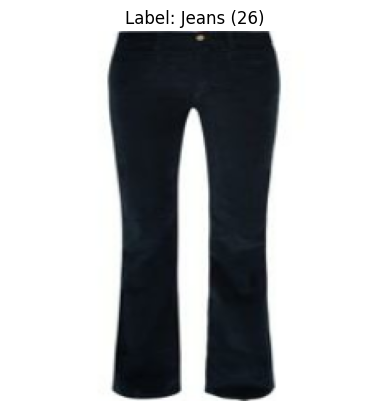

In [26]:
def get_image_and_label_at_index(dataset, target_index):
    for index, (image, label) in enumerate(dataset.unbatch()):
        if index == target_index:
            return image.numpy(), label.numpy()

# 원하는 인덱스 지정
target_index = 250

# 이미지와 레이블 가져오기
image, label = get_image_and_label_at_index(limited_dataset_train, target_index)

# 이미지와 레이블을 시각화합니다.
plt.imshow(image)
plt.title(f"Label: {categories[label]} ({label})")
plt.axis('off')
plt.show()

모델 만들기

In [27]:
num_classes = len(categories)
img_height = 224
img_width = 224

model = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [28]:
epochs = 1

history = model.fit(limited_dataset_train, validation_data=limited_dataset_val, epochs=epochs)

2023-04-28 23:51:05.180318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [14000]
	 [[{{node Placeholder/_1}}]]
/usr/local/Caskroom/miniforge/base/envs/mlops/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


438/438 [==============================] - ETA: 0s - loss: 2.4711 - accuracy: 0.3398

2023-04-28 23:59:07.227655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [2000]
	 [[{{node Placeholder/_1}}]]


438/438 [==============================] - 498s 1s/step - loss: 2.4711 - accuracy: 0.3398 - val_loss: 2.1572 - val_accuracy: 0.4120


In [29]:
test_loss, test_acc = model.evaluate(dataset_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

2023-04-28 23:59:23.557279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [4000]
	 [[{{node Placeholder/_1}}]]


125/125 - 29s - loss: 2.2130 - accuracy: 0.3753 - 29s/epoch - 235ms/step

Test accuracy: 0.3752500116825104
